**Advait Kinikar**

**Director id: kinikara**

**UID: 120097997**

**PROBLEM 1:**

In the following code cell, we mount to Google drive so that its features can be used to A) To read our 'proj2_v2.mp4' file and
           B) save the output video

In [1]:
# mounting to google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

MessageError: Error: credential propagation was unsuccessful

In this code snippet, here we give the path to folder we will be accessing

In [ ]:
# accessing the folder
path_to_folder = "ENPM673/Project2"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673/Project2


Here, we import all the necessary libraries 1) Opencv -for reading,writing images and videos as well as performing image processing opertions on the video frame. 2) Numpy- to access the image array and process the image by array indexing.

In [ ]:
# importing necessary libraries
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

The following function 'variance_of_laplacian' is the part of the video processing pipeline. Here, first a kernel, which is a 3x3 array is created. The kernel is:

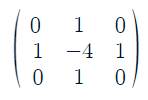

Then, it is convoluted over the image. Then, simply the variance i.e. the standard deviation squared is taken. This variance value is used to filter out the blur frames. If the value is lesser than certain threshold(say 150), then that frame is not processed upon. The implementation of this later in the code.                           





In [ ]:
#Find Variance of the laplacian
def variance_of_laplacian(frame):
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1],[0, 1, 0]])
    laplacian = cv.filter2D(frame, cv.CV_64F, laplacian_kernel) #when you use depth as -1, the datatype of image is uint8, which has limited precision. When you use cv.CV_64F, you get more precision (higher decimal precision and more range of numbers)
    x = np.abs(laplacian - laplacian.mean())**2
    var = x.mean()
    return var

In the following function 'segmentation_from_background', a binary image of the video frame is created. Then 'cv.morphologyEx' function is used to fill any black spots in on the white paper. The function uses kernel to fill the spots. The size of the kernel determines how many spots will be filled. The larger the size of the kernel, more spots will be filled. Following is a binary frame from the video

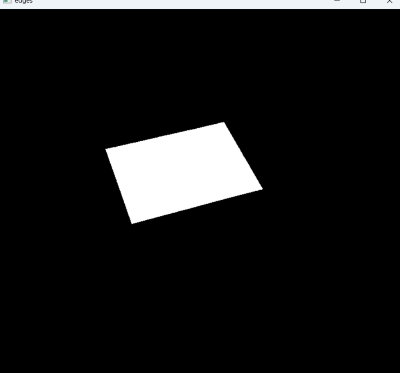



In [ ]:
# Convert Frame to binary image
def segmentation_from_background(frame):
    grayscale = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    threshold = cv.threshold(grayscale,225,255,cv.THRESH_BINARY)
    kernel = np.ones((125, 125), np.uint8)
    image = cv.morphologyEx(threshold[1], cv.MORPH_CLOSE, kernel)
    return image

Now, Hough Transform is a technique used to detect lines or curves in an image. It is typically used in edge detection, when gradient based techniques fail, because of noise or other factors.
**1)**It is necessary to detect edges of lines before Hough Transform is used. Hence, a canny or sobel detector is used.
**2)**Now, Hough Transform, works by converting the image space(x,y) to parameter space(r,theta). Let us consider a line, the equation of line in image space is y=mx+c. Hence, its equation in parameter space is b=-mx+y. The problem with this  is that it doesnt work for vertical lines. Hence, the line is converted to polar form, where x=rcos(theta), y=rsin(theta) and hence r=xcos(theta)+ysin(theta) becomes the equation of line.
**3)**Now, each edge point in image space, corresponds to a line or sinusoidal curve in parameter space. The parameter space is represented as an array, in which, the elements are parameters of the lines being detected.
**4)**Each edge point votes for potential lines that pass through it in the parameter space. This is done by considering all possible lines that could pass through each edge point and incrementing the corresponding cells in the parameter space.Cells corresponding to lines that receive votes from multiple edge points will have higher values.
**5)** After the voting process, the accumulator array is thresholded to identify the most prominent lines. The higher the threshold value, the more prominent lines will be detected
**6)** The openCV function 'cv.HoughLines' returns a list of lines, in which the list contains tuples (rho,theta) which are the parameters of the lines
**7)**These parameters are used to find x,y and hence the line
**8)**In the function below, i have further segregated the lines into vertical and horizontal lines, which are later used to find corners. In short, it works like this: if the difference between 2 x points is less than some threshold, then the line is vertical and if the difference between two y points is less than some threshold, then the line is horizontal.
**9)**The euclidean distance is used to find the length of lines and hence filter out shorter lines.


In [ ]:
#Find the lines using hough transform
def hough_transform(frame):
    diff1 = 1000
    diff2 = 2000
    vertical = []
    horizontal = []
    points = []
    parameters = cv.HoughLines(frame, rho=1, theta=np.pi/180, threshold=42)
    if parameters is None:
        return None
    else:
        for rho,theta in parameters[:,0]:
            x = rho*np.cos(theta)
            y = rho*np.sin(theta)
            x1 = int(x + 1000 * (-np.sin(theta)))
            y1 = int(y + 1000 * (np.cos(theta)))
            x2 = int(x - 1000 * (-np.sin(theta)))
            y2 = int(y - 1000 * (np.cos(theta)))

# Filter short lines
            line_length = np.sqrt(((x2 - x1)**2)+((y2 - y1)**2))
            if line_length < 1800:
                pass
# Keep few dominant lines
            else:
                if len(points) < 4:
                    if abs(x2 - x1) < diff1:
                        if len(vertical) < 2:
                            vertical.append(((x1,y1),(x2,y2)))
                            points.append(((x1,y1),(x2,y2)))
                    elif abs(y2 - y1) < diff2:
                        if len(horizontal)<2:
                            horizontal.append(((x1,y1),(x2,y2)))
                            points.append(((x1,y1),(x2,y2)))


        return points,vertical,horizontal

The function 'intersection' below, gives the intersection between vertical and horizontal lines. These intersection are essentially the corners of the paper. The equation to find the intersection between two lines is given by:
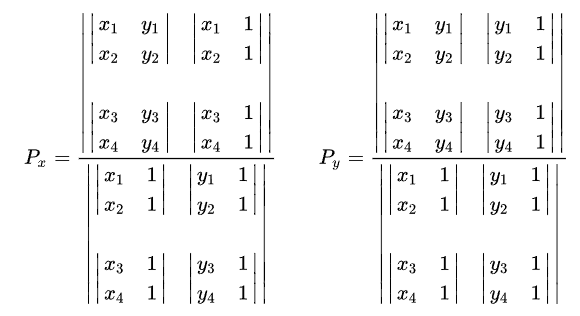 [1]

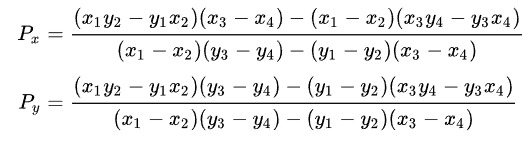 [2]

References:
**[1]** https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection
**[2]** https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection

In [ ]:
# Find the intersection between vertical and horizontal lines
def intersection(vertical,horizontal):
    intersections = []
    for i in range(len(vertical)):
        for j in range(len(horizontal)):
            (x1,y1),(x2,y2) = vertical[i]
            (x3, y3), (x4, y4) = horizontal[j]
            x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / \
                 ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
            y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / \
                 ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
            intersections.append((int(x),int(y)))

    return intersections



The function corner_verification, just takes a frame, turns it into binary image and then applies the harris corner detector to find the corners in the image.

In [ ]:
# To verify the corners detected
def corner_verification(frame):
    image = segmentation_from_background(frame)
    corners = cv.cornerHarris(image, 9, 29, 0.01)
    dilate = cv.dilate(corners,None)
    frame[dilate > 0.2 * dilate.max()] = [0, 255, 255]
    return frame

The function 'pipeline' is just all the processes that are done on the video frames.
**1)** First, all the blur frames are filtered out by using the variance of laplace method. The variacnce of laplace is calculated. If the variance of laplace of the frame is less than 120, then the frame is filtered out. Else, it is processed upon
**2)** The first process is to segment out the white regions in the frame. An example image, is shown above.
**3)**Then, the edges are detected using canny edge detector. Following is a frame from the video

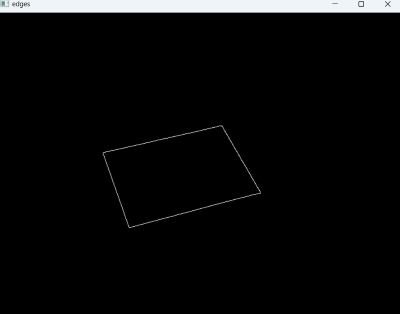

**4)** Then, Hough Transforms are used to detect lines. The function 'hough_transform' returns the lines, vertical as well as horizontal
**5)** These vertical and horizontal lines are then used by the 'intersection' function to find intersections between lines. These intersections are essentially the corners of the paper.
**6)** The intersections are plotted on the image in red
**7)** The Harris corner detector is used to verify the corners. These are plotted in yellow. Following is an example

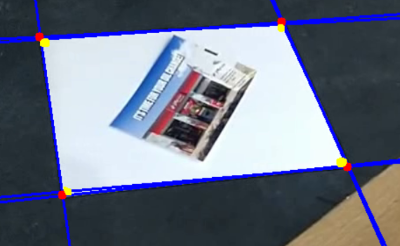

In [ ]:
# All the processes done on the video
def pipeline(frame):
    variance = variance_of_laplacian(frame)
    if variance > 120:
        segmented_image = segmentation_from_background(frame)
        edges = cv.Canny(segmented_image, threshold1=200, threshold2=240)
        points,vertical,horizontal = hough_transform(edges)
        if points is not None:
            for pt1,pt2 in points:
                cv.line(frame,pt1,pt2,(255,0,0),thickness=2)
            corners = intersection(vertical,horizontal)
            for corner in corners:
                cv.circle(frame,corner,4,(0,0,255),thickness=-1)
            corner_verification(frame)
            return frame
    else:
        return False

Here, first the video is opened and read. Then each frame is individually passed throught the processing pipeline (in a while) loop.A counter is set to count the blurry frames.

In [ ]:
# Read, process and write the videos
video = cv.VideoCapture("proj2_v2.mp4")
fps = video.get(cv.CAP_PROP_FPS)
length = int(video.get(cv.CAP_PROP_FRAME_COUNT))
width = video.get(cv.CAP_PROP_FRAME_WIDTH)
height = video.get(cv.CAP_PROP_FRAME_HEIGHT)
count = 0
codec = cv.VideoWriter_fourcc(*'XVID')
output = cv.VideoWriter('Project2/Video.mp4',codec,10,(int(width),int(height)))
while True:
    ret, frames = video.read()

    if ret:
        video_process = pipeline(frames)
        if video_process is not False:
            if video_process is not None:
                output.write(video_process)
        else:
            count +=1
    else:
        break

    if cv.waitKey(int(1000/fps)) and 0xFF == ord('d'):
        break

video.release()
cv.destroyAllWindows()

In [ ]:
print(f"The total number of frames are {length}")
print(f"The number of frames removed  are (for the given threshold) are {count}")

The total number of frames are 386
The number of frames removed  are (for the given threshold) are 199


**PROBLEM 2**
**PART A**

Following is the pipeline for creating a panaromic image:
1) Extracting features from the images
2) Mapping those features
3) Creating transformation matrices for feature points
4) Mapping the pixels of original image to new positions in target image using the transformation matrices

Here, additional 'pprint' from 'pprint' is imported so that it becomes easier to visualize the homography matrix

In [ ]:
# import libraries
from pprint import pprint


All the images are read

In [ ]:
# Read the images
img1 = cv.imread("PA120275.JPG")
img2 = cv.imread("PA120274.JPG")
img3 = cv.imread("PA120273.JPG")
img4 = cv.imread("PA120272.JPG")

In the function 'feature_extraction', the image is passed through the 'detectAndCompute' method of 'sift' object, to get the features i.e the keypoints and the descriptors of image. The reason for using SIFT was that SIFT features are detected at local minima, which means that they capture information about the local structure of image, which can be useful for image stitching. SIFT is also robust against noise and other image degradations

In [ ]:
# Extract Features from the image
def feature_extraction(img):
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img,None)
    return keypoints,descriptors

In the following function 'match_feature', the features are matched using 'knnMatch' from the bfMatcher object. Instead of finding single best match, KNN finds K closest matches. For this, it uses euclidean distance, to measure the length between features in the feature space. In the function below, if the ratio of the distances, is below 0.7, the matches are considered valid. The output image is the visualization image for the matches. 'source' and 'destinations' are used to get transformations and hence are used in homography

In [ ]:
# Match the features of 2 images
def match_features(imgA,imgB,keypointsA,keypointsB,descA,descB):
    bfMatcher = cv.BFMatcher()
    matches = bfMatcher.knnMatch(descA,descB,k=3)
    ratio_thresh = 0.7
    valid_matches = []
    for m,n,p in matches:
        if m.distance < ratio_thresh*n.distance:
            valid_matches.append([m])

    width = imgA.shape[1]
    height = imgA.shape[0]
    output_image = np.empty((height, 2*width, 3), dtype=np.uint8)
    image_match = cv.drawMatchesKnn(imgA,keypointsA,imgB,keypointsB,valid_matches,outImg=output_image,flags=2)
    source = np.float32([keypointsA[m.queryIdx].pt for [m] in valid_matches]).reshape(-1, 1, 2)
    destination = np.float32([keypointsB[m.trainIdx].pt for [m] in valid_matches]).reshape(-1, 1, 2)
    return output_image,source,destination

Following is function to find homographies of the images. RANSAC is used to reject any outliers and make the algorithm more robust

In [ ]:
# find homography in images
def homography_in_images(source_pts,dest_pts):
    matrix,mask = cv.findHomography(source_pts,dest_pts,cv.RANSAC,5)
    return matrix

Here, the features of a given images are extracted

In [ ]:
# Extract Features of given image
img1_keypoints,img1_descriptors = feature_extraction(img1)
img2_keypoints,img2_descriptors = feature_extraction(img2)
img3_keypoints,img3_descriptors = feature_extraction(img3)
img4_keypoints,img4_descriptors = feature_extraction(img4)

Here the features of the given images are matched

In [ ]:
# Match Features
image1_2,source_pts1,dest_pts2 = match_features(img1,img2,img1_keypoints,img2_keypoints,img1_descriptors,img2_descriptors)
image2_3,source_pts2,dest_pts3 = match_features(img2,img3,img2_keypoints,img3_keypoints,img2_descriptors,img3_descriptors)
image3_4,source_pts3,dest_pts4 = match_features(img3,img4,img3_keypoints,img4_keypoints,img3_descriptors,img4_descriptors)

Features matched between Frame 1 and Frame 2


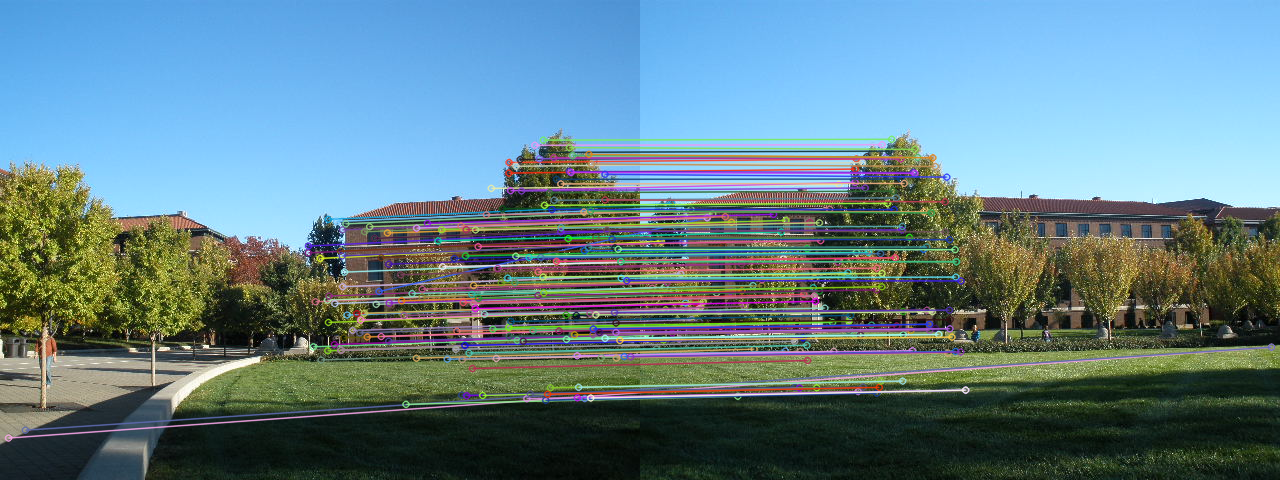

In [ ]:
print("Features matched between Frame 1 and Frame 2")
cv2_imshow(image1_2)


Features matched between Frame 2 and Frame 3


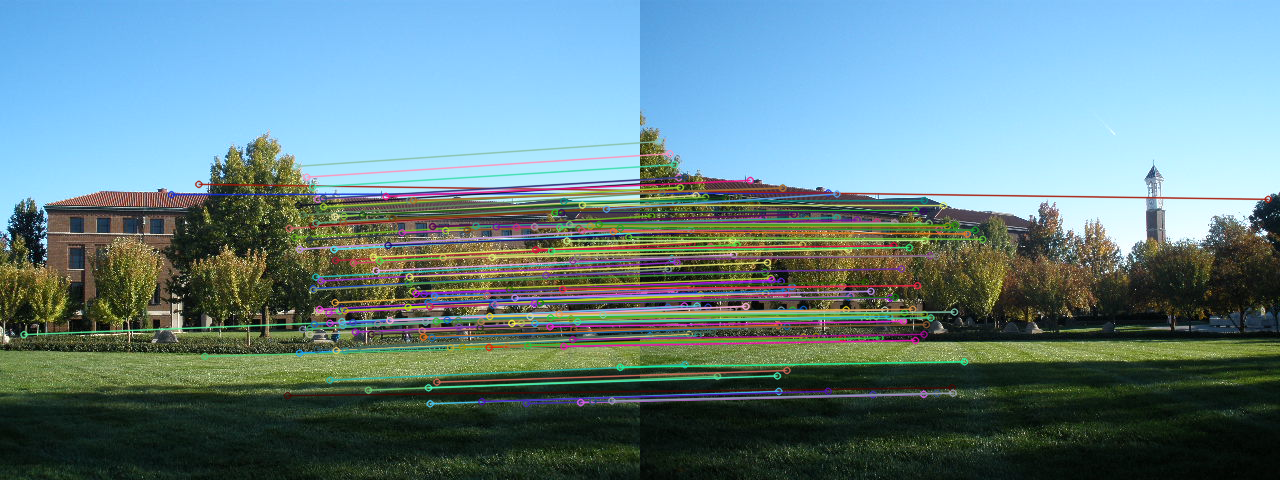

In [ ]:
print("Features matched between Frame 2 and Frame 3")
cv2_imshow(image2_3)

Features matched between Frame 3 and Frame 4


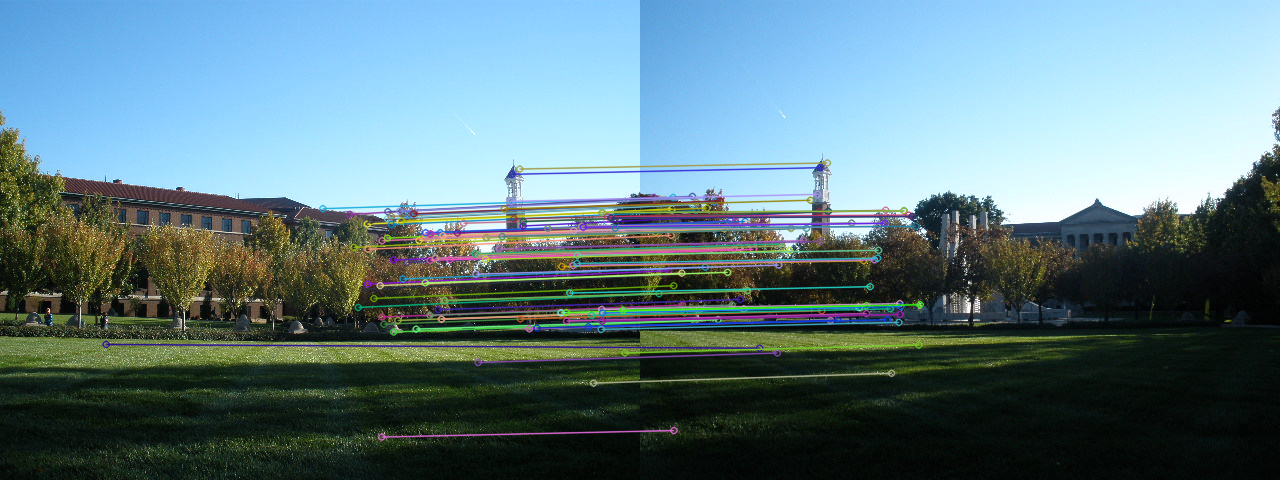

In [ ]:
print("Features matched between Frame 3 and Frame 4")
cv2_imshow(image3_4)

Here, the feature points of the images are identified and transformation matrices are obtained

In [ ]:
homography1_2 = homography_in_images(source_pts1,dest_pts2)
homography2_3 = homography_in_images(source_pts2,dest_pts3)
homography3_4 = homography_in_images(source_pts3,dest_pts4)

In [ ]:
pprint(homography1_2)
pprint(homography2_3)
pprint(homography3_4)

array([[ 1.13238334e+00, -5.48488548e-02, -3.26405687e+02],
       [ 1.11950299e-01,  1.09769401e+00, -5.75251370e+01],
       [ 2.31795937e-04, -7.22482615e-07,  1.00000000e+00]])
array([[ 1.13423988e+00, -6.21960389e-02, -3.06804829e+02],
       [ 1.26791061e-01,  1.11438545e+00, -7.11324077e+01],
       [ 2.12927819e-04,  3.38248175e-05,  1.00000000e+00]])
array([[ 1.16342203e+00, -5.42263153e-02, -3.81260557e+02],
       [ 1.22463476e-01,  1.11192082e+00, -6.47659882e+01],
       [ 2.98369736e-04, -5.46739117e-05,  1.00000000e+00]])


Here, thet pixels of original image are transforemed and then mapped to target positions on a new image. First the warped image is obtained. Then a canvas is created on which the warped image and the target image are blended to create a new image. It can be seen that warping allows to align seemlessly

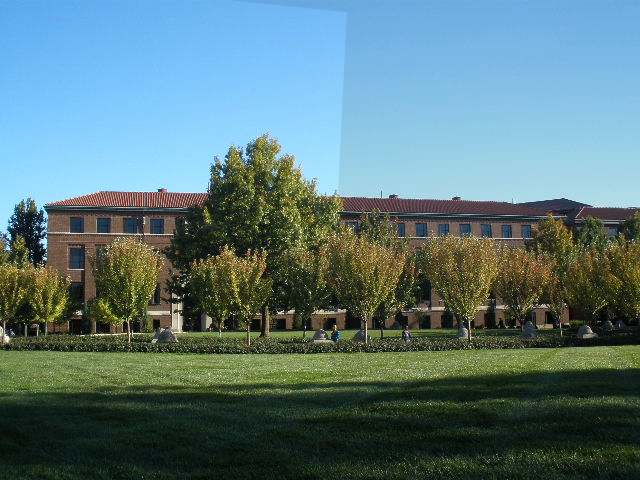

In [ ]:
img1_warped = cv.warpPerspective(img1, homography1_2, (img1.shape[1] + img2.shape[1], img1.shape[0]))
dummy_image1 = np.zeros_like(img1_warped)
dummy_image1[:,:img1.shape[1]] = img2
stitched_image1 = cv.addWeighted(img1_warped,0.1,dummy_image1,0.9,0)
imgA = stitched_image1[:,:stitched_image1.shape[1]//2]
cv2_imshow(imgA)

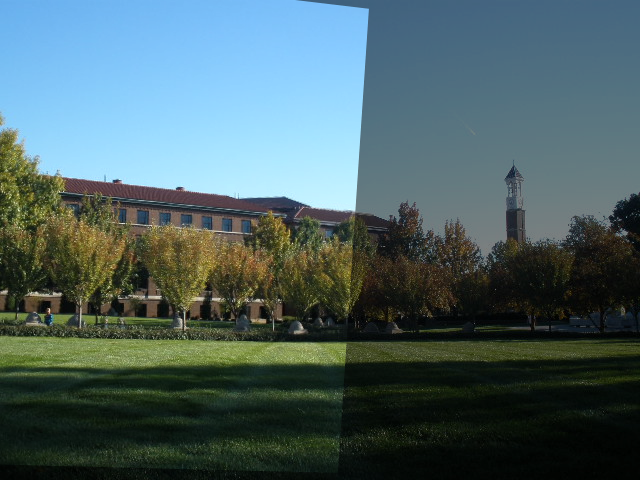

In [ ]:
img2_warped = cv.warpPerspective(img2,homography2_3,(img2.shape[1] + img3.shape[1], img2.shape[0]))
dummy_image2 = np.zeros_like(img2_warped)
dummy_image2[:,:img3.shape[1]] = img3
stitched_image2 = cv.addWeighted(img2_warped,0.5,dummy_image2,0.5,0)
imgB = stitched_image2[:,:stitched_image2.shape[1]//2]
cv2_imshow(imgB)

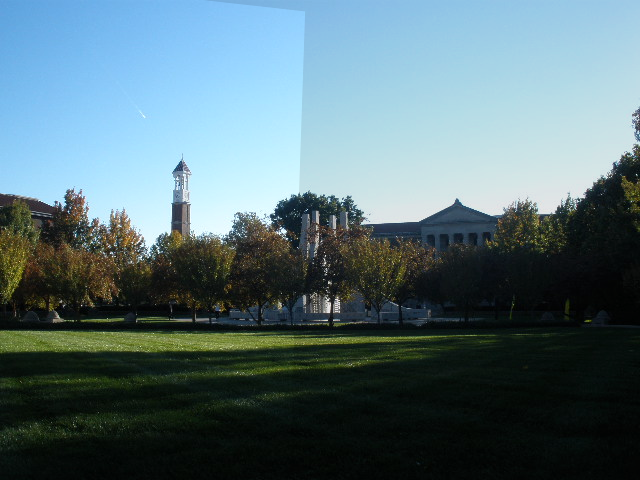

In [ ]:
img3_warped = cv.warpPerspective(img3,homography3_4,(img3.shape[1] + img4.shape[1], img3.shape[0]))
dummy_image3 = np.zeros_like(img3_warped)
dummy_image3[:,:img4.shape[1]] = img4
stitched_image3 = cv.addWeighted(img3_warped,0.1,dummy_image3,0.9,0)
imgC = stitched_image3[:,:stitched_image3.shape[1]//2]
cv2_imshow(imgC)

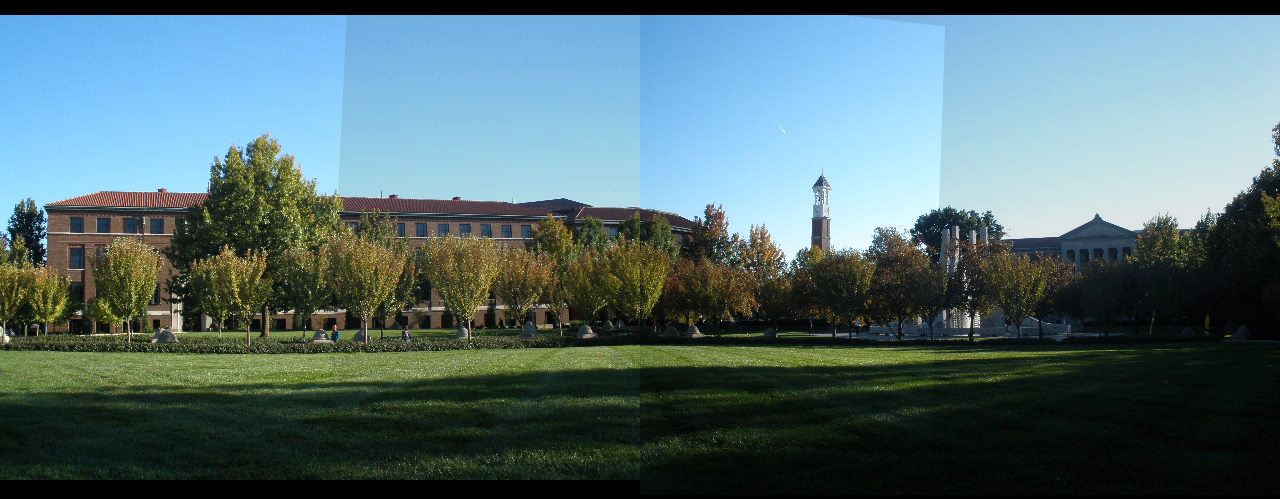

In [ ]:
width = int(stitched_image1.shape[1])
height = int(stitched_image1.shape[0]*1.04)


final = np.zeros((height,width,3),dtype='uint8')
final[:imgA.shape[0],:imgA.shape[1]] = imgA
final[15:imgA.shape[0]+15,imgA.shape[1]:imgA.shape[1]+imgC.shape[1]] = imgC
final[:15,:] = 0

width = int(final.shape[1]*3)
height = int(final.shape[0])
final1 = cv.resize(final,(height,width))
cv2_imshow(final)


In the above image, it can be seen that only the parts of image that correspond to features found in both images are transformed or 'warped'. This happens because, it ensures that features in both images are aligned correctily, to get a seamless panaroma. Hence the road or path in the first image is not included.


Note: the above image can be seen as having different intensities. This is because of the threshold that has been set for the images being blended. Those values can be changed to change the intensities


**PROBLEM 2**
**PART B**

When the camera is only allowed to rotate around the center, consistency in the scenes appearance is maintained. This makes process of aligning and stitching easier. Furthermore, when camera is only rotated around the center,the cameras viewing angles are almost constant, hence, distortions due to change in viewing angles are minimized. Additionally, parameters like focal length and image features remain constant, making it easier for feature mapping
